In [11]:
import numpy as np
import astropy.units as u
from astropy import constants as const
from scipy.integrate import quad
import matplotlib.pyplot as plt 
from scipy.optimize import minimize
from scipy.optimize import curve_fit
import corner

For a flat universe we have:

\begin{align}
d_L &= c(1+z) \int_{0}^{z} \frac{dz'}{H(z')}\\
&= \frac{c}{H_0} (1+z) \int_{0}^{z} \frac{dz'}{\sqrt{\Omega_M (1+z')^{3} + \Omega_{\Lambda} (1+z')^{3(1+w)}}}
\end{align}

In [12]:
H0 = 70
Omega_M = 0.3
Omega_lambda = 0.7
w = -1

M = -18.3  # Absolute magnitude supernova type 1a    this is a free paramters, dont know what this means

In [13]:
def H_inv(z, H0, Omega_M, Omega_lambda, w):
    '''
    1/H(z) for a given cosmology.
    '''
    return 1/(H0*np.sqrt((Omega_M*(1+z)**3)+(Omega_lambda*(1+z)**(3*(1+w)))))

def luminosity_distance(z, H0, Omega_M, Omega_lambda, w):
    '''
    Luminosity distance for a given cosmological model of a flat universe.
    
    Parameters
    ----------------------------------------
    z
        Redshift
    H0
        Hubble constant in km/Mpc/s
    Omega_M
        Mass density
    Omega_lambda
        Dark energy density
    w
        Dark energy EOS
    
    Output
    ----------------------------------------
    d_L
        Luminosity distance in Mpc
    '''
    c = const.c.to(u.km/u.s).value
    
    d_L = []
    
    for z_val in z:
        integral = quad(H_inv, 0, z_val, args=(H0, Omega_M, Omega_lambda, w))
        d_L.append(integral[0] * (1+z_val) * c)
    
    return np.array(d_L)

def angular_distance(z, H0, Omega_M, Omega_lambda, w):
    '''
    Angular diameter distance for a given cosmological model of a flat universe.
    
    Parameters
    ----------------------------------------
    z
        Redshift
    H0
        Hubble constant in km/Mpc/s
    Omega_M
        Mass density
    Omega_lambda
        Dark energy density
    w
        Dark energy EOS
    
    Output
    ----------------------------------------
    d_A
        Angular diameter distance in Mpc
    '''

    d_A = luminosity_distance(z, H0, Omega_M, Omega_lambda, w)
    
    return d_A/(1+z)**2

def luminosity(P_bolo, z, H0, Omega_M, Omega_lambda, w):
    
    d_L = luminosity_distance(z, H0, Omega_M, Omega_lambda, w)*u.Mpc
    
    return (P_bolo*4*np.pi*(d_L.to(u.cm))**2).value

def luminosity_distance_GRB(L, P_bolo):
    dL_GRB = np.sqrt(L / (4 * np.pi * P_bolo))*u.cm
    
    return(dL_GRB.to(u.Mpc).value)

def distance_modulus_dL(dL):
    return 25 + 5 * np.log10(dL)


def L_Epeak(z, E_peak, params):
    
    log_L = params[0] + params[1] * np.log10(E_peak*(1+z)/300)
    
    return (10**log_L)

# Part 1: SNIa m-z diagram

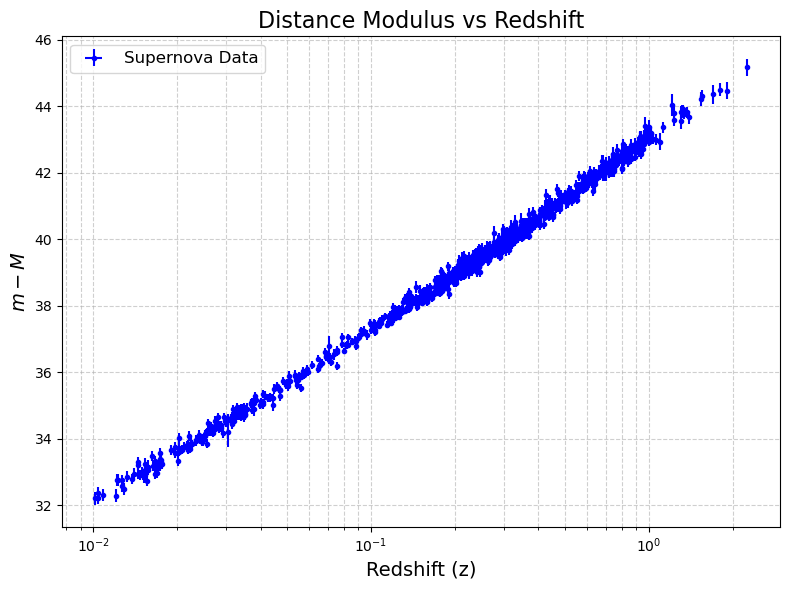

In [14]:
z, err_z, m, err_m = np.loadtxt(f'lcparam_full_long_zhel.txt', skiprows=1, usecols=(1, 3, 4, 5), unpack=True)

distance_modulus = m - M

# Plot m - M vs z
plt.figure(figsize=(8, 6))
plt.errorbar(z, distance_modulus, xerr=err_z, yerr=err_m, fmt= '.', c='blue', label='Supernova Data')
plt.xlabel('Redshift (z)', fontsize=14)
plt.ylabel(r'$m - M$', fontsize=14)
plt.xscale('log')
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.title('Distance Modulus vs Redshift', fontsize=16)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


# Part 2: Minimizing

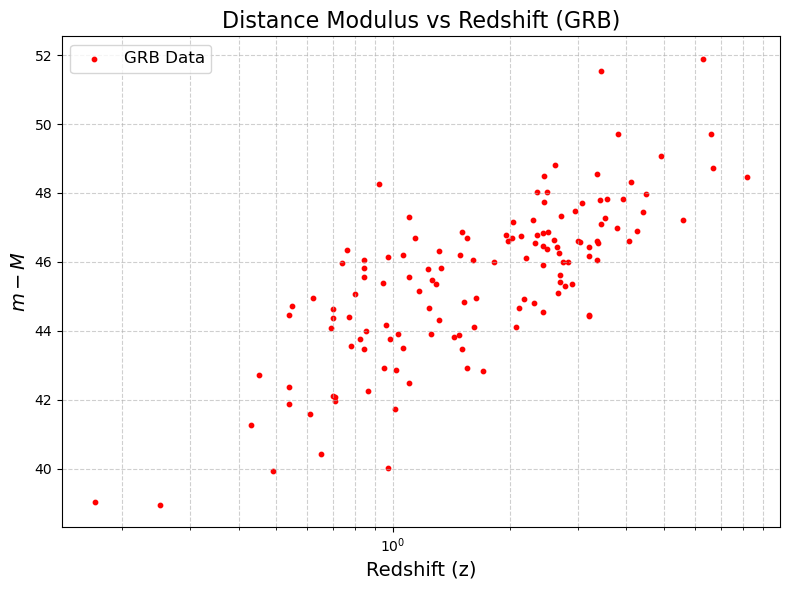

Fitted parameters: a = 52.1624, b = 2.0212


In [15]:
z, P_bolo, err_P_bolo, E_peak, err_E_peak = np.loadtxt(f'GRBdata.txt', skiprows=1, usecols=(1, 2, 3, 4, 5), unpack=True)

# Know for sure
L = luminosity(P_bolo, z, H0, Omega_M, Omega_lambda, w)

# Fit a log-linear relation between L and E_peak
log_L = np.log10(L)
log_term = np.log10((E_peak * (1 + z)) / 300)

def chi_squared(params):
    a, b = params
    model = a + b * log_term
    chi2 = np.sum(((model - log_L)**2) / (b**2 * (err_E_peak / E_peak)**2 + (err_P_bolo / P_bolo)**2))
    return chi2
    
initial_params = [1, 1]
fit_result = minimize(chi_squared, initial_params, method='Nelder-Mead')
a_fit, b_fit = fit_result.x

# Distance modulus calculation using the fit
L_new = L_Epeak(z, E_peak, fit_result.x)
dL_GRB = luminosity_distance_GRB(L_new, P_bolo)
distance_modulus = distance_modulus_dL(dL_GRB)

# Plot m - M vs. z
plt.figure(figsize=(8, 6))
plt.scatter(z, distance_modulus, s=10, c='red', label='GRB Data')
plt.xlabel('Redshift (z)', fontsize=14)
plt.ylabel(r'$m - M$', fontsize=14)
plt.xscale('log')
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.title('Distance Modulus vs Redshift (GRB)', fontsize=16)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Print the fit results
print(f"Fitted parameters: a = {a_fit:.4f}, b = {b_fit:.4f}")

# Part 3

In [16]:
z_1, d_A_1 = np.loadtxt('galaxy_clusters_z_angdist.txt', skiprows=1, usecols=(0, 1), unpack=True)

z_2, d_A_2 = np.loadtxt('galaxy_clusters_z_angdist_2.txt', skiprows=1, usecols=(0, 1), unpack=True)

z = np.concatenate((z_1, z_2))
d_A = np.concatenate((d_A_1, d_A_2*1000))

d_L = d_A*(1+z)**2

distance_modulus = distance_modulus_dL(d_L)

# Read from here on

In [17]:
def curve_SNIa(z, H0, Omega_M, Omega_lambda, w, M):
    '''
    Curve to fit for SNIa.
    '''
    m = M + 25 + 5*np.log10(luminosity_distance(z, H0, Omega_M, Omega_lambda, w))
    
    return m

def mod_z_info(initial_params):
    '''
    Get the (m-M) vs. z points from the data.
    '''
    H0, Omega_M, Omega_lambda, w, M = initial_params
    
    # SNIa data
    z_SNI, err_z_SNI, m_SNI, err_m_SNI = np.loadtxt(f'lcparam_full_long_zhel.txt', skiprows=1, usecols=(1, 3, 4, 5), unpack=True)
    
    #distance_modulus_SNI_dist = 25 + 5*np.log10(luminosity_distance(z_SNI, H0, Omega_M, Omega_lambda, w))
    
    distance_modulus_SNI = m_SNI - M
    
    #delta_SNI = distance_modulus_SNI_dist - distance_modulus_SNI
    
    # GRB data
    z_GRB, P_bolo_GRB, err_P_bolo_GRB, E_peak_GRB, err_E_peak_GRB = np.loadtxt(f'GRBdata.txt', skiprows=1, usecols=(1, 2, 3, 4, 5), unpack=True)

    ## Luminosity of GRBs (eq. 1)
    L_GRB = luminosity(P_bolo_GRB, z_GRB, H0, Omega_M, Omega_lambda, w)

    ## Fit a log-linear relation between L and E_peak (eq. 2-3)
    log_L_GRB = np.log10(L_GRB)
    log_term_GRB = np.log10((E_peak_GRB * (1 + z_GRB)) / 300)
    
    def chi_squared(params):
        a, b = params
        model = a + b * log_term_GRB
        chi2 = np.sum(((model - log_L_GRB)**2) / (b**2 * (err_E_peak_GRB / E_peak_GRB)**2 + (err_P_bolo_GRB / P_bolo_GRB)**2))
        return chi2

    initial_fit = [1, 1]
    fit_result = minimize(chi_squared, initial_fit, method='Nelder-Mead')
    a_fit, b_fit = fit_result.x

    ## Distance modulus calculation using the fit (eq. 4-5)
    L_new_GRB = L_Epeak(z_GRB, E_peak_GRB, fit_result.x)
    dL_GRB = luminosity_distance_GRB(L_new_GRB, P_bolo_GRB)
    distance_modulus_GRB = distance_modulus_dL(dL_GRB)
    
    #distance_modulus_GRB_dist = 25 + 5*np.log10(luminosity_distance(z_GRB, H0, Omega_M, Omega_lambda, w))
    
    #delta_GRB = distance_modulus_GRB_dist - distance_modulus_GRB
    
    # Galaxy cluster data
    z_1, d_A_1 = np.loadtxt('galaxy_clusters_z_angdist.txt', skiprows=1, usecols=(0, 1), unpack=True)

    z_2, d_A_2 = np.loadtxt('galaxy_clusters_z_angdist_2.txt', skiprows=1, usecols=(0, 1), unpack=True)

    z_clusters = np.concatenate((z_1, z_2))
    d_A_clusters = np.concatenate((d_A_1, d_A_2*1000))

    d_L_clusters = d_A_clusters*(1+z_clusters)**2

    distance_modulus_clusters = distance_modulus_dL(d_L_clusters)
    
    #distance_modulus_clusters_dist = 25 + 5*np.log10(luminosity_distance(z_clusters, H0, Omega_M, Omega_lambda, w))
    
    #delta_clusters = distance_modulus_clusters_dist - distance_modulus_clusters
    
    
    z = np.concatenate((z_SNI, z_GRB, z_clusters))
    
    distance_modulus = np.concatenate((distance_modulus_SNI, distance_modulus_GRB, distance_modulus_clusters))
    
    #distance_modulus_dist = np.concatenate((distance_modulus_SNI_dist, distance_modulus_GRB_dist, distance_modulus_clusters_dist))
    
    #delta = distance_modulus_dist - distance_modulus
    
    # Plot m - M vs. z
    plt.figure(figsize=(8, 6))
    plt.scatter(z_SNI, distance_modulus_SNI, s=10, c='red', label='SNIa data')
    #plt.plot(z_SNI, distance_modulus_SNI_dist, '--r', label='SNIa data')
    plt.scatter(z_GRB, distance_modulus_GRB, s=10, c='green', label='GRB data')
    #plt.plot(z_GRB, distance_modulus_GRB_dist,'--g', label='GRB data')
    plt.scatter(z_clusters, distance_modulus_clusters, s=10, c='blue', label='Galaxy cluster data')
    #plt.plot(z_clusters, distance_modulus_clusters_dist,'--b', label='Galaxy cluster data')
    plt.xlabel('Redshift (z)', fontsize=14)
    plt.ylabel(r'$m - M$', fontsize=14)
    plt.xscale('log')
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    plt.title('Distance Modulus vs Redshift', fontsize=16)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return(z, distance_modulus)

def bootstrapping(initial_params):
    z, distance_modulus= mod_z_info(initial_params)
    
    new_indices = np.random.choice(np.arange(len(z)), len(z))
    
    z_new = [z[i] for i in new_indices]
    distance_modulus_new = [distance_modulus[i] for i in new_indices]
    return(z_new, distance_modulus_new)

def curve(z, H0,Omega_M, Omega_lambda, w, M):
    dist_mod = 25 + 5*np.log10(luminosity_distance(z, H0, Omega_M, Omega_lambda, w))
    
    return dist_mod

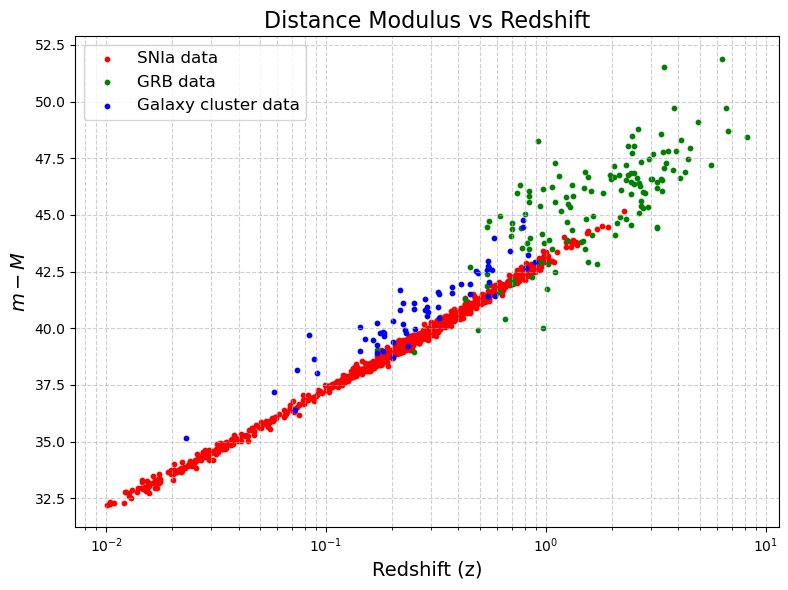

C:\Users\muham\AppData\Local\Temp\ipykernel_14280\4011587411.py:5: RuntimeWarning: invalid value encountered in sqrt
  return 1/(H0*np.sqrt((Omega_M*(1+z)**3)+(Omega_lambda*(1+z)**(3*(1+w)))))
C:\Users\muham\AppData\Local\Temp\ipykernel_14280\4011587411.py:34: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral = quad(H_inv, 0, z_val, args=(H0, Omega_M, Omega_lambda, w))


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 3000.

In [18]:
def param_est(initial_params, plot=False):

    z_new, distance_modulus_new = bootstrapping(initial_params)

    results = curve_fit(curve, z_new, distance_modulus_new, p0=initial_params, maxfev = 3000)

    H0,Omega_M, Omega_lambda, w, M = results[0]
    print(results[0])

    z = np.linspace(0, 10)
    dist_mod = curve(z, H0, Omega_M, Omega_lambda, w, M)

    if plot:
        plt.figure(figsize=(8, 6))
        plt.scatter(z_new, distance_modulus_new, label = 'Sampled data')
        plt.plot(z, dist_mod,color='red' ,label = 'Fitted curve')
        plt.xlabel('Redshift (z)', fontsize=14)
        plt.ylabel(r'$m - M$', fontsize=14)
        plt.xscale('log')
        plt.grid(True, which='both', linestyle='--', alpha=0.6)
        plt.title('Distance Modulus vs Redshift', fontsize=16)
        plt.legend(fontsize=12)
        plt.tight_layout()
        plt.show()

    return(results[0])

initial_params = [H0, Omega_M, Omega_lambda, w, M]
estimates = np.zeros((100, len(initial_params)))
for i in range(100):
    estimates[i] = param_est(initial_params, plot=True)